In [1]:
!pip install tensorflow pandas scikit-learn opencv-python


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


In [4]:
import zipfile

zip_path = "/content/soil-classification-part-2.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
print(os.listdir("/content/soil_competition-2025"))


['test', 'sample_submission.csv', 'test_ids.csv', 'train_labels.csv', 'train']


In [17]:
# Define paths (updated test directory)
train_dir = '/content/soil_competition-2025/train'
test_dir = '/content/soil_competition-2025/test/'
train_labels_path = '/content/soil_competition-2025/train_labels.csv'
test_ids_path = '/content/soil_competition-2025/test_ids.csv'
submission_path = '/content/soil_competition-2025/submission10.csv'

In [7]:
# Step 1: Load and verify training labels
train_labels = pd.read_csv(train_labels_path)
print("Column names:", train_labels.columns.tolist())
print("First few rows:\n", train_labels.head())
print("Unique labels:", train_labels['label'].unique())
print("Label distribution:\n", train_labels['label'].value_counts())

Column names: ['image_id', 'label']
First few rows:
            image_id  label
0  img_ed005410.jpg      1
1  img_0c5ecd2a.jpg      1
2  img_ed713bb5.jpg      1
3  img_12c58874.jpg      1
4  img_eff357af.jpg      1
Unique labels: [1]
Label distribution:
 label
1    1222
Name: count, dtype: int64


In [8]:
# Import libraries (from your setup)
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.ensemble import IsolationForest
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
# Confirm all labels are 1 (soil)
train_labels['binary_label'] = train_labels['label']  # Already 1

In [10]:
# Step 2: Extract features using ResNet50
def extract_features(image_ids, directory, target_size=(224, 224)):
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    features = []
    for img_id in image_ids:
        img_path = os.path.join(directory, img_id)
        try:
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            img = preprocess_input(img)  # ResNet50-specific preprocessing
            img = np.expand_dims(img, axis=0)
            feature = model.predict(img, verbose=0)
            features.append(feature.flatten())
        except Exception as e:
            print(f"Error loading {img_id}: {e}")
            features.append(np.zeros(2048))  # Fallback for corrupted/missing images
    return np.array(features)

In [11]:
# Extract features for training images
print("Extracting features for training images...")
train_image_ids = train_labels['image_id']
X_train = extract_features(train_image_ids, train_dir)
print(f"Training features shape: {X_train.shape}")

Extracting features for training images...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training features shape: (1222, 2048)


In [12]:
# Step 3: Train Isolation Forest
print("Training Isolation Forest...")
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
iso_forest.fit(X_train)

Training Isolation Forest...


IsolationForest(contamination=0.1, random_state=42)

In [13]:
# Step 4: Validation (using a split of training data)
# Since all labels are 1, evaluate inlier detection
X_train_split, X_val, train_ids_split, val_ids = train_test_split(
    X_train, train_image_ids, test_size=0.2, random_state=42
)
val_predictions = iso_forest.predict(X_val)
val_scores = iso_forest.decision_function(X_val)
print(f"Validation inliers (1) vs. outliers (-1): {np.bincount(val_predictions + 1)}")

Validation inliers (1) vs. outliers (-1): [ 23   0 222]


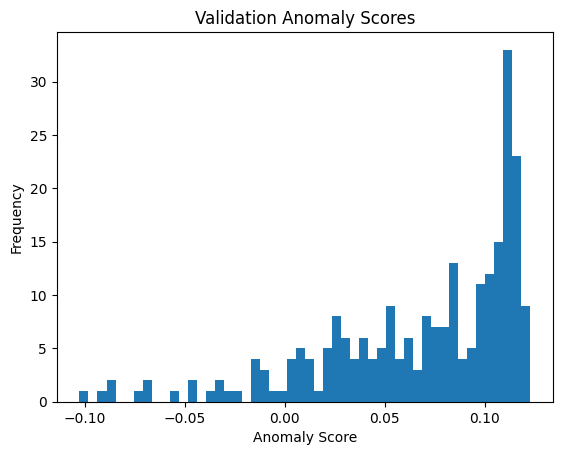

In [14]:
# Plot anomaly scores for validation
plt.hist(val_scores, bins=50)
plt.title('Validation Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Step 5: Predict on test set
print("Extracting features for test images...")
test_ids = pd.read_csv(test_ids_path)
test_image_ids = test_ids['image_id']
X_test = extract_features(test_image_ids, test_dir)
print(f"Test features shape: {X_test.shape}")

# Predict: 1 (inlier, soil), -1 (outlier, not-soil)
predictions = iso_forest.predict(X_test)
binary_predictions = np.where(predictions == 1, 1, 0)  # Convert to 1 (soil), 0 (not-soil)

Extracting features for test images...
Test features shape: (967, 2048)


In [18]:
# Step 6: Create submission
submission = pd.DataFrame({
    'image_id': test_image_ids,
    'labels': binary_predictions  # Match sample_submission.csv column name
})
submission.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")

# Verify submission format
sample_submission = pd.read_csv('/content/soil_competition-2025/sample_submission.csv')
print("Sample submission format:\n", submission.head())
print("Generated submission:\n", submission.head())
print(f"Submission shape: {submission.shape} (should have 967 rows)")

Submission saved to /content/soil_competition-2025/submission10.csv
Sample submission format:
                                image_id  labels
0  6595f1266325552489c7d1635fafb88f.jpg       1
1  4b614841803d5448b59e2c6ca74ea664.jpg       1
2  ca30e008692a50638b43d944f46245c8.jpg       0
3  6a9046a219425f7599729be627df1c1a.jpg       1
4  97c1e0276d2d5c2f88dddbc87357611e.jpg       1
Generated submission:
                                image_id  labels
0  6595f1266325552489c7d1635fafb88f.jpg       1
1  4b614841803d5448b59e2c6ca74ea664.jpg       1
2  ca30e008692a50638b43d944f46245c8.jpg       0
3  6a9046a219425f7599729be627df1c1a.jpg       1
4  97c1e0276d2d5c2f88dddbc87357611e.jpg       1
Submission shape: (967, 2) (should have 967 rows)
